# Read in the data

In [2]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
print(survey_fields + ["sat_score"])

['rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 'saf_p_11', 'com_p_11', 'eng_p_11', 'aca_p_11', 'saf_t_11', 'com_t_11', 'eng_t_11', 'aca_t_11', 'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11', 'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11', 'sat_score']


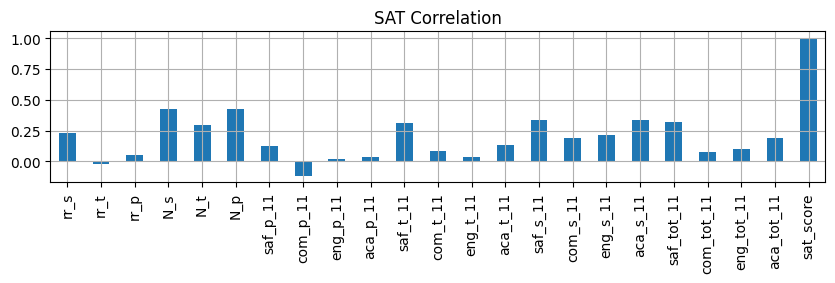

In [14]:
corr = combined[survey_fields + ["sat_score"]].corr()['sat_score']
axs = corr.plot.bar(x="sat_score", y=survey_fields, figsize=(10, 2), grid=True, title="SAT Correlation")
plt.show()


### Correlations observed
The safety percived by teachers and students, and the students academic expectations are a positive correlation with the SAT score. 

### Relationship between students sensation of safety and SAT score

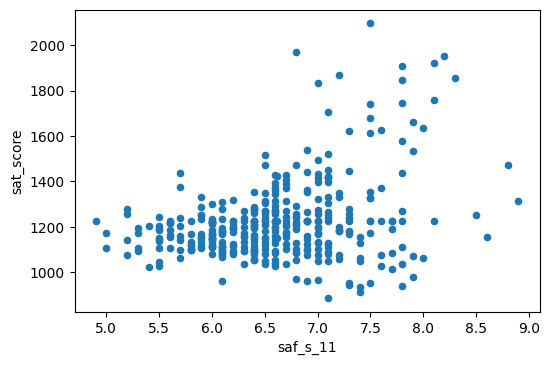

In [15]:
combined.plot.scatter(x="saf_s_11", y="sat_score")
plt.show()

The correlation to students safety sensation is not very strong, but we can see that values higher than 7.5 have clearly a more tendency to good result in the SAT tests.

### Mean of students safety sensation by borough 

In [16]:
combined.groupby('boro')["saf_s_11"].agg(numpy.mean)

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64

The mean on each borough shows that students percive safety at school in the same level, with a slightly increase in Manhattan and Queens.
That is surpracing result, because it means that safety in school its not correlated with economic wealth, being Saten Island the "richest" borough with Manhattan.

### Racial correlation with SAT Score

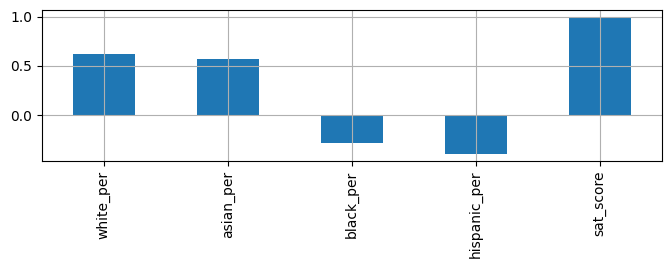

In [17]:
racial_cols = ["white_per", "asian_per", "black_per", "hispanic_per"]
corr = combined[racial_cols + ["sat_score"]].corr()['sat_score']
corr.plot.bar(x="sat_score", y=racial_cols, figsize=(8, 2), grid=True)
plt.show()


Its clear that the white and asian percentage have a strong positive correlation and, on the other hand, black and hispanic percentage have a negative correlation.

### Hispanic correlation with SAT score 

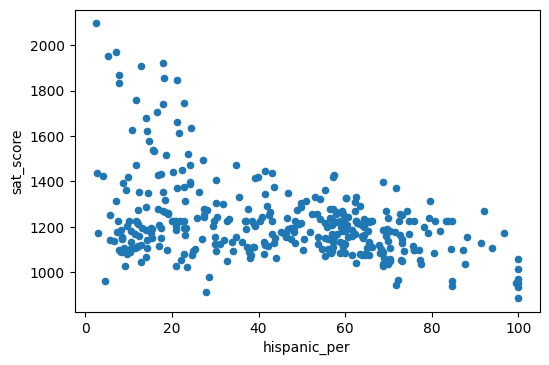

In [19]:
combined.plot.scatter(x="hispanic_per", y="sat_score")

The scatter plot above that is comparing hispanic percentage and de SAT score is showing a negative correlation between the two fields, that means that schools with higher percentage of hispanic students have a low average score in SAT 

In [26]:
combined.loc[combined["hispanic_per"] > 95, ["SCHOOL NAME", "hispanic_per", "sat_score"]]


,SCHOOL NAME,hispanic_per,sat_score
44,MANHATTAN BRIDGES HIGH SCHOOL,99.8,1058.0
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,96.7,1174.0
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,99.8,1014.0
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,99.4,951.0
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,99.8,934.0
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,99.8,970.0
253,MULTICULTURAL HIGH SCHOOL,99.8,887.0
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,100.0,951.0


Most of the schools with hispanic percentage higher than 95% are schools that have the goal of educate hispanic immigrants and help them to learn english. 

In [27]:
combined.loc[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800), ["SCHOOL NAME", "hispanic_per", "sat_score"]]

,SCHOOL NAME,hispanic_per,sat_score
37,STUYVESANT HIGH SCHOOL,2.4,2096.0
151,BRONX HIGH SCHOOL OF SCIENCE,7.2,1969.0
187,BROOKLYN TECHNICAL HIGH SCHOOL,7.9,1833.0
327,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,7.9,1868.0
356,STATEN ISLAND TECHNICAL HIGH SCHOOL,5.3,1953.0


Schools with hipanic percentage  below 10% and SAT score over 1800 are schools with heavy academic load, full of extracurricular activities including AP preparation. They have advance subjects and offer the posibility of make personal research. One common characteristic is the use and investigation in technology related subjects. Also, most of them have a very big amount of students, wich comfirms a previous conclusion of a positive correlation between the number of students and the SAT score.    

### Gender Correlation 

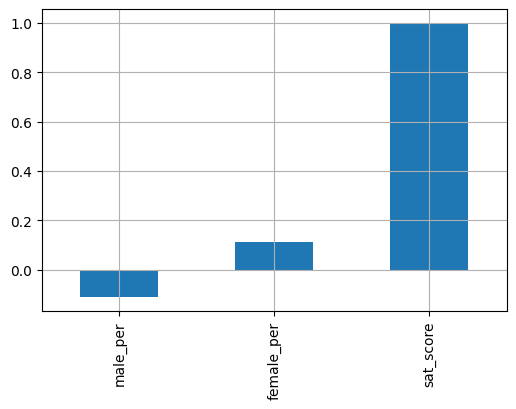

In [30]:
corr = combined[["male_per", "female_per", "sat_score"]].corr()["sat_score"]
corr.plot.bar(x=["male_per", "female_per"], y="sat_score", grid=True)
plt.show()

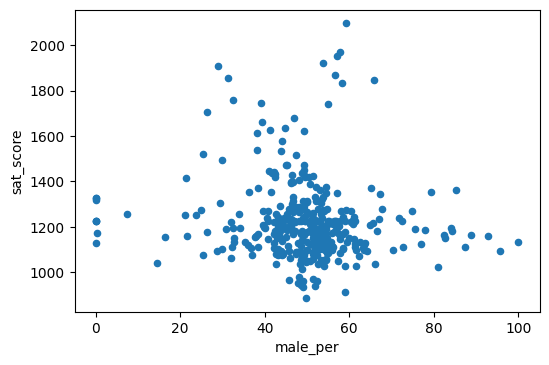

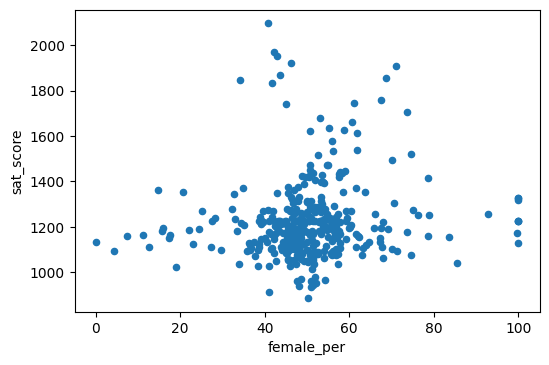

In [33]:
combined.plot.scatter(x="male_per", y="sat_score")
combined.plot.scatter(x="female_per", y="sat_score")

Based on the previous plots, there is no visible or strong correlation between gender and SAT score

In [36]:
combined.loc[(combined["female_per"] > 60) & (combined["sat_score"] > 1700), ["female_per", "SCHOOL NAME", "sat_score"]]

,female_per,SCHOOL NAME,sat_score
5,68.7,BARD HIGH SCHOOL EARLY COLLEGE,1856.0
26,67.5,ELEANOR ROOSEVELT HIGH SCHOOL,1758.0
60,61.0,BEACON HIGH SCHOOL,1744.0
61,73.6,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,1707.0
302,71.1,TOWNSEND HARRIS HIGH SCHOOL,1910.0


The percentage of females in this schools with SAT score over 1700 its not too high, and there are not a lot of them, so its easy to conclude that gender its not a field that have a correlation with SAT score.

### AP exams correlation

Creating a column of AP takers percentage instead of using the total enrollment
so the result its not biased 

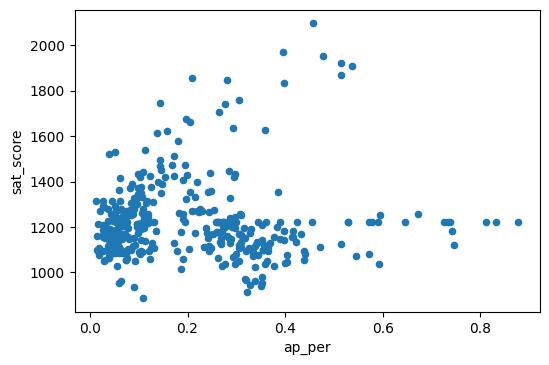

In [38]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]
combined.plot.scatter(x="ap_per", y="sat_score")

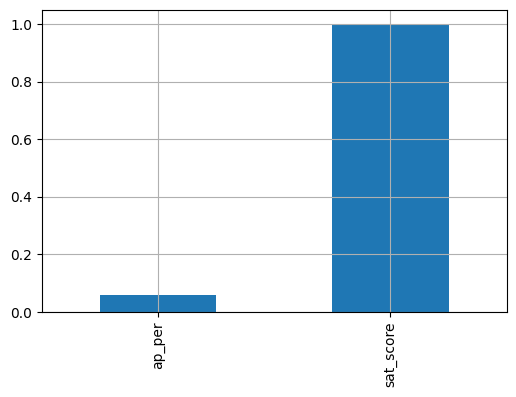

In [41]:
corr = combined[["ap_per", "sat_score"]].corr()["sat_score"]
corr.plot.bar(grid=True)
plt.show()

Its easy to think that the percentage of AP test taker will influence the SAT score, but the results above show that there is not a correlation at all, what a is really interesting conclusion 